# Multi LSTM layers stacking baseline for JPX Tokyo Stock Exchange Prediction


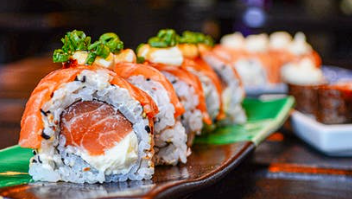


Thank you for your checking this notebook.

This is my baseline for "JPX Tokyo Stock Exchange Prediction" competition [(Link)](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview) with Keras - LSTM. I will try to stack 2 ~ 4 LSTM layers and see whether is there any interesting point or not.

If you think this notebook is useful, please give your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [Preprocessing Data](#prep)
4. [Define & Train Model](#model)
5. [Prediction with API](#pred)
6. [Conclusion](#conclusion)
7. [Reference](#ref)


<a id='config'></a>

---
# 1. Import Library & Set Config
---

[Back to Contents](#top)

In [ ]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random, cudf
import pickle as pkl
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime, timedelta

# Pre-Processing
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

# Model
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, BatchNormalization, \
multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

In [ ]:
# Configuration
DEBUG = False
PATH_INPUT = r'../input/jpx-tokyo-stock-exchange-prediction'
TIME_WINDOW = 16
LEARNING_RATE = 0.001
n_layers = 4
n_hidden = 256
drop_rate = 0.2
batch_size=50

if DEBUG:
    TRAIN_PERIOD = ['2021.11.01', '2021.12.03']
    epc = 2
else:
    TRAIN_PERIOD = ['2021.06.01', '2021.12.03']
    epc = 10

<a id='load'></a>

---
# 2. Load Data

Based on the [Data Description](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data), first I am loading the "stock_prices.csv" under "train_files" and use the "close" & "target" data to train LSTM model.

Update on 11th Jun. , concatenate "stock_prices.csv" under "supplemental_files" for final submittion.

- ../train_files/stock_prices.csv: Price info of stock covering the main training period.
- ../supplemental_files/stock_prices.csv: Price info of stock updated with new data during the main phase of the competition in early May, early June, and roughly a week before the submissions are locked.


---

[Back to Contents](#top)

In [ ]:
dfPriceTrain = cudf.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target'])
dfPriceTrain['Date'] = cudf.to_datetime(dfPriceTrain['Date'])
dfPriceTrain.set_index('Date', inplace=True)
dfPriceTrain = dfPriceTrain.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPriceTrain

In [ ]:
dfPriceSuppl = cudf.read_csv(PATH_INPUT + r'/supplemental_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target'])
dfPriceSuppl['Date'] = cudf.to_datetime(dfPriceSuppl['Date'])
dfPriceSuppl.set_index('Date', inplace=True)
dfPriceSuppl

In [ ]:
dfPriceTrain = cudf.concat([dfPriceTrain, dfPriceSuppl], axis=0)
dfPriceTrain

<a id='prep'></a>

---
# 3. Preprocessing Data

1. Logarithmic transform with log1p
2. Change scale btw. 0 - 1 by MinMaxScaler
3. Filter by each "SecuritiesCodes", create training dataset. The shape of features is [ "batch_size" : "TIME_WINDOW" : "num of features" ] and the shape of "Target" is ["batch_size":1:1].
4. If there is nan. value, interpolate that.

---

[Back to Contents](#top)

In [ ]:
dfPriceTrain = dfPriceTrain.to_pandas()
listFeatures = ['Open', 'High', 'Low', 'Close', 'Volume']
dfPriceTrain[listFeatures] = dfPriceTrain[listFeatures].apply(np.log1p)
dfPriceTrain

In [ ]:
mm = MinMaxScaler()
dfPriceTrain[listFeatures] = mm.fit_transform(dfPriceTrain[listFeatures])

pkl.dump(mm, open('scaler.pkl', 'wb'))

In [ ]:
listSC = dfPriceTrain['SecuritiesCode'].unique().tolist()
X = []
Y = []

for sc in tqdm(listSC):
    dfTemp = dfPriceTrain[dfPriceTrain['SecuritiesCode'] == sc]
    dfTemp = dfTemp.interpolate()
    dfTemp = dfTemp.dropna(how='any')
    iterN = (dfTemp.shape[0] - TIME_WINDOW + 1)
    
    for i in range(iterN):
        x = dfTemp[listFeatures].iloc[i:(i+TIME_WINDOW)].to_numpy()
        y = dfTemp['Target'].iat[(i+TIME_WINDOW-1)].reshape([1, 1])

        X.append(x)
        Y.append(y)

X = np.array(X)
Y = np.array(Y) 

assert X.shape[0] == Y.shape[0], "Shape of X or Y are not correct."
print(f'Shape of train data: X = {X.shape}, Y = {Y.shape}.')

In [ ]:
assert np.count_nonzero(np.isnan(X)) == 0, f'There is nan in X data. {np.argwhere(np.isnan(X))}'

<a id='model'></a>

---
# 4. Define & Train Model

- Try stacking of 2 ~ 4 LSTM layers. Dropout layer would be also applied.
- Split X for training (80%) and validation (20%)
---

[Back to Contents](#top)

In [ ]:
def define_model(dfx, dfy, n_layers=2, n_hidden=32, drop_rate=0.2):
    
    model = Sequential()
    
    for i in range(n_layers - 1):
        model.add(LSTM(units=n_hidden, return_sequences=True,
                      input_shape=(dfx.shape[1], dfx.shape[2])))
        model.add(Dropout(drop_rate))
    
    model.add(LSTM(units=n_hidden, return_sequences=False))
    model.add(Dropout(drop_rate))
    model.add(Dense(units=1))
    
    opt = Adam(lr=LEARNING_RATE, clipnorm=1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    model.summary()
    
    return model

In [ ]:
def train_model(dfx, dfy, model):

    es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(dfx, dfy, validation_split=0.2, epochs=epc, verbose=1,
                        callbacks=[es], batch_size=batch_size)
    train_mae = history.history['mae']
    valid_mae = history.history['val_mae']
    
    return model, train_mae, valid_mae

In [ ]:
def plot_mae(train_mae, valid_mae):
    plt.plot(train_mae, label='train mae'),
    plt.plot(valid_mae, label='validation mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.title('train vs. validation accuracy (mae)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=
    2)
    plt.show()

In [ ]:
startTime = time.time()

trainX = X
trainY = Y

model = define_model(trainX, trainY, n_layers=n_layers, n_hidden=n_hidden, drop_rate=drop_rate)

model, train_mae, valid_mae = train_model(trainX, trainY, model)

model.save(f'model.h5')

plot_mae(train_mae, valid_mae)

print(f'Training time was {time.time() - startTime:.2f} [s].\n')

<a id='pred'></a>

---
# 5. Prediction with time-series API

- Following the explanation from the organizer [here](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview/evaluation)
- As recommended in [this web page](https://logmi.jp/tech/articles/325898), using try and except to continue the prediction during the loop by API.
- My model is using past data as input but API gives me only one day data. So I need to prepare two data frame, one is about data before date which API gives and another one is to keep data which API gives during the loop.

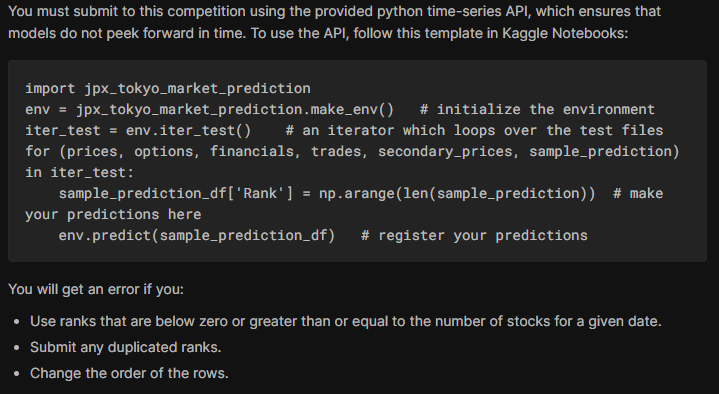


---

[Back to Contents](#top)

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
count = 0
countExcept = 0

# Prepare dataframe with past data for prediction.
dfPrice = pd.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume'])
dfPrice['Date'] = pd.to_datetime(dfPrice['Date'])
dfPrice.set_index('Date', inplace=True)
dfPrice = dfPrice.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPrice

In [ ]:
dfPriceSuppl = pd.read_csv(PATH_INPUT + r'/supplemental_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume'])
dfPriceSuppl['Date'] = pd.to_datetime(dfPriceSuppl['Date'])
dfPriceSuppl.set_index('Date', inplace=True)
dfPriceSuppl

In [ ]:
dfPrice = pd.concat([dfPrice, dfPriceSuppl], axis=0)
dfPrice

In [ ]:
def prepare_data(df, listSC, listFeatures, mm):
    '''Pre-processing and prepare dataset.'''
    
    print('Start preparing data')
    
    X = []
    for sc in tqdm(listSC):
        dfTemp = df[df['SecuritiesCode'] == sc]
        dfTemp[listFeatures] = dfTemp[listFeatures].apply(np.log1p)
        dfTemp[listFeatures] = mm.transform(dfTemp[listFeatures])
        dfTemp = dfTemp.interpolate()
        dfTemp = dfTemp.fillna(0)
        dfTemp = dfTemp.tail(TIME_WINDOW)
        x = dfTemp[listFeatures].to_numpy()
        X.append(x)
    
    X = np.array(X)
    
    print('End preparing data')
    
    assert X.shape == (len(listSC), TIME_WINDOW, len(listFeatures)), "Shape of X is not correct."
    return X

In [ ]:
def predict_rank(X, model, sample_prediction, listSC):
    '''Predict Target value and make a ranking. Return submittion df.'''
    
    print('Start prediction rank')
    
    Y = model.predict(X)
    dfY = pd.DataFrame(Y.reshape(-1, 1))
    dfSC = pd.DataFrame(listSC)
    dfTemp = pd.concat([dfSC, dfY], axis=1)
    dfTemp.columns = ['SecuritiesCode', 'prediction']
    dfTemp['Rank'] = dfTemp["prediction"].rank(ascending=False,method="first") -1
    dfTemp['Rank'] = dfTemp['Rank'].astype(int)
    dfTemp = dfTemp.drop('prediction', axis=1)
    sample_prediction = sample_prediction.drop('Rank', axis=1)
    dfSub = sample_prediction.merge(dfTemp, on='SecuritiesCode', how='left')

    print('End prediction rank')
    
    assert dfSub.shape == (len(listSC), 3), "Shape of dfSub is not correct."
    return dfSub    

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    try:
        prices = prices[['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume']]
        prices['Date'] = pd.to_datetime(prices['Date'])
        prices.set_index('Date', inplace=True)
        
        dfPrice = pd.concat([dfPrice, prices], axis=0)
        dfTarget = dfPrice.copy()
        
        X = prepare_data(dfTarget, listSC, listFeatures, mm)
        dfSub = predict_rank(X, model, sample_prediction, listSC)
        
        if DEBUG:
            display(dfSub)
        
        env.predict(dfSub)
        count += 1
              
    except:
        env.predict(sample_prediction)
        count += 1
        countExcept += 1

In [ ]:
print(f'Finished prediction. {countExcept} / {count} times exception occurred. \n')

<a id='conclusion'></a>

---
# 6. Conclusion

Thank you for your checking this notebook.

I tried several pattern of stacking LSTM here. (Changing number of layers, number of neurons, etc)

However the result was not showing stability and looks like this model easiliy overfit to the train data.

So LSTM might be too much for this task and other algorizm would be fit to this.

Here is my next approach with LGBMRanker which was used in 1st place solution of former JPX competition.

[JPX_LGBMRanker_Learning_from_past_JPX_competition](https://www.kaggle.com/code/hechtjp/jpx-lgbmranker-learning-from-past-jpx-competition)

If you find an interesting thing here, please click upvote :)

---

[Back to Contents](#top)

<a id='ref'></a>

---
# 7. Reference
1. [JPX_EDA_with_cudf_&_Key_Events_Japan_Market](https://www.kaggle.com/code/hechtjp/jpx-eda-with-cudf-key-events-japan-market?scriptVersionId=94993105)
2. [How to stack multiple lstm in keras?](https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras)
3. [ポイントを押さえればTime-seriesコンペは怖くない
堅牢で速いコードを書くためのテクニックと心構え](https://logmi.jp/tech/articles/325898)


---

[Back to Contents](#top)